In [ ]:
import albumentations as A
import numpy as np
import onnx
import onnxruntime
from albumentations.pytorch import ToTensorV2
from PIL import Image

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from utils.dice import dice_score


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


In [ ]:
model_path = "../../checkpoints/best.onnx"
# image_path = "../../images/SM.png"
image_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/DSC_0055.jpg"
gt_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/MASK.PNG"


In [ ]:
onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model)


In [ ]:
session = onnxruntime.InferenceSession(model_path)


In [ ]:
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(25, 10))
plt.imshow(image)

print(image.size)


In [ ]:
transform = A.Compose(
    [
        A.LongestMaxSize(1024),
        A.ToFloat(max_value=255), # [0, 255] -> [0.0, 1.0]
        ToTensorV2(), # HWC -> CHW
    ],
)
aug = transform(image=np.asarray(image))
img = aug["image"]

img = img.unsqueeze(0) # -> 1CHW

In [ ]:
inputs = {
    session.get_inputs()[0].name: to_numpy(img),
}

outs = session.run(None, inputs)

img_out = outs[0][0][0] # extract HW
img_out = img_out * 255 # [0.0, 255.0]
img_out = img_out.clip(0, 255) 
img_out = np.uint8(img_out) # [0, 255]
img_out = Image.fromarray(img_out, "L") # PIL img

# plt.figure(figsize=(25, 10))
# plt.imshow(img_out, cmap=plt.cm.gray)


In [ ]:
inputs = {
    session.get_inputs()[0].name: to_numpy(img),
}

outs = session.run(None, inputs)

img_out = outs[0][0][0] # extract HW
img_out = sigmoid(img_out) # -> [0.0, 1.0]
img_out = img_out * 255 # [0.0, 255.0]
img_out = np.uint8(img_out) # [0, 255]
img_out = Image.fromarray(img_out, "L") # PIL img

plt.figure(figsize=(25, 10))
plt.imshow(img_out, cmap=plt.cm.gray)


In [ ]:
from skimage import measure, draw

# Find contours at a constant value of 0.8
contours = measure.find_contours(np.asarray(img_out))

# Display the image and plot all contours found
plt.figure(figsize=(19, 18))
plt.imshow(img_out, cmap=plt.cm.gray)

lenc = [len(c) for c in contours]
indexs = np.argsort(lenc)
l = indexs[-1]

# plt.plot(contours[l][:, 1], contours[l][:, 0], linewidth=2, c="red")

# on estime l'ellipse
ellipse = measure.EllipseModel()
ellipse.estimate(contours[l])

# on récupère les coords des points de l'ellipse
cx, cy, a, b, theta = ellipse.params
ex, ey = draw.ellipse_perimeter(int(cx), int(cy), int(a), int(b), orientation=theta, shape=img_out.size[::-1])

plt.scatter(ey, ex, c="green", s=0.5)
plt.scatter(cy, cx, c="green", s=0.5)

# # on estime le cercle
circle = measure.CircleModel()
circle.estimate(contours[l])

# on récupère les coords des points du cercle
cx, cy, r = circle.params
ex, ey = draw.circle_perimeter(int(cx), int(cy), int(r), shape=img_out.size[::-1])

plt.scatter(ey, ex, c="blue", s=0.5)
plt.scatter(cy, cx, c="blue", s=0.5)


# mutilresolution zoom

In [ ]:
factor = image.size[0] / img_out.size[0]
taille = min(a, b) * factor
percentage = 0.1
size = taille / percentage

img = image.crop((cy*factor - size, cx*factor - size/1.5, cy*factor + size, cx*factor + size/1.5))

transform = A.Compose(
    [
        A.LongestMaxSize(1024),
        A.ToFloat(max_value=255), # [0, 255] -> [0.0, 1.0]
        ToTensorV2(), # HWC -> CHW
    ],
)
aug = transform(image=np.asarray(img))
img = aug["image"]

img = img.unsqueeze(0) # -> 1CHW

In [ ]:
inputs = {
    session.get_inputs()[0].name: to_numpy(img),
}

outs = session.run(None, inputs)

img_out = outs[0][0][0] # extract HW
img_out = sigmoid(img_out) # -> [0.0, 1.0]
img_out = img_out * 255 # [0.0, 255.0]
img_out = np.uint8(img_out) # [0, 255]
img_out = Image.fromarray(img_out, "L") # PIL img

plt.figure(figsize=(25, 10))
plt.imshow(img_out, cmap=plt.cm.gray)


In [59]:
image = Image.open(image_path).convert("RGB")
ground_truth = Image.open(gt_path).convert("L")

Image.MAX_IMAGE_PIXELS = 5000000000                                                                                              

dices = []
percentages = np.linspace(0.01, 0.35, 100)

for p in percentages:
    size = taille / p 
    print(p, end="\r")

    img = image.crop((cy * factor - size, cx * factor - size, cy * factor + size, cx * factor + size))
    gt = ground_truth.crop((cy * factor - size, cx * factor - size, cy * factor + size, cx * factor + size))

    transform = A.Compose(
        [
            A.LongestMaxSize(1024),
            A.ToFloat(max_value=255),  # [0, 255] -> [0.0, 1.0]
            ToTensorV2(),  # HWC -> CHW
        ],
    )
    aug = transform(image=np.asarray(img))
    img = aug["image"]
    img = img.unsqueeze(0)  # -> 1CHW

    inputs = {
        session.get_inputs()[0].name: to_numpy(img),
    }

    outs = session.run(None, inputs)

    img_out2 = outs[0][0][0] # extract HW
    img_out2 = sigmoid(img_out2) # -> [0.0, 1.0]
    img_out2 = img_out2 > 0.5 # {False, True}
    img_out2 = np.uint8(img_out2) # [0, 1]
    img_out2 = torch.tensor(img_out2)

    aug = transform(image=np.array(gt))
    gt = aug["image"]
    gt = gt > 0.1 # {False, True}
    gt = np.uint8(gt) # [0, 1]
    gt = torch.tensor(gt)

    dice = dice_score(gt, img_out2, logits=False)
    dices.append(dice)

    # plt.figure(figsize=(25, 10))
    # plt.imshow(Image.fromarray(gt.squeeze(0).numpy()), cmap=plt.cm.gray)

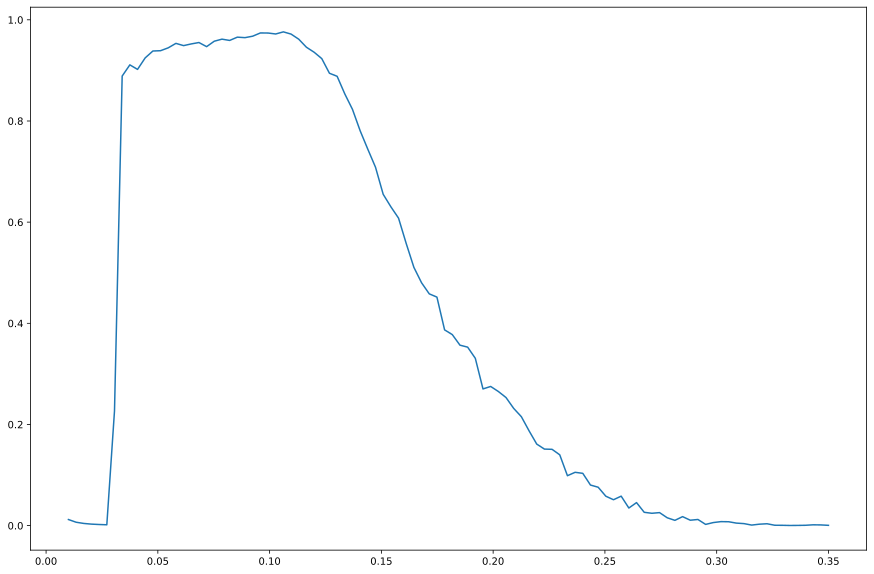

In [60]:
plt.figure(figsize=(15, 10))
plt.plot(percentages, dices)


# Dice(resolution)

In [ ]:
image_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/DSC_0050.jpg"
gt_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/MASK.PNG"

image = Image.open(image_path).convert("RGB")
image = torch.tensor(np.uint8(image))

ground_truth = Image.open(gt_path).convert("L")
ground_truth = torch.tensor(np.uint8(ground_truth))

dices = []
rezs = range(128, 1920+4, 4)

for rez in rezs:

    print(rez, end="\r")

    transform = A.Compose(
        [
            A.LongestMaxSize(rez),
            A.ToFloat(max_value=255), # [0, 255] -> [0.0, 1.0]
            ToTensorV2(), # HWC -> CHW
        ],
    )
    aug = transform(image=np.array(image))
    img = aug["image"]
    img = img.unsqueeze(0) # -> 1CHW

    inputs = {
        session.get_inputs()[0].name: to_numpy(img),
    }
    outs = session.run(None, inputs)

    img_out = outs[0][0][0] # extract HW
    img_out = sigmoid(img_out) # -> [0.0, 1.0]
    img_out = img_out > 0.5 # {False, True}
    img_out = np.uint8(img_out) # [0, 1]
    img_out = torch.tensor(img_out)

    aug = transform(image=np.array(ground_truth))
    gt = aug["image"]
    gt = gt > 0.1 # {False, True}
    gt = np.uint8(gt) # [0, 1]
    gt = torch.tensor(gt)

    dice = dice_score(gt, img_out, logits=False)
    dices.append(dice)


In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(rezs, dices)
